In [1]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
print("")

## Seeding
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
t = 64
X = []
for direct in os.listdir("dataset/"):
    if direct != ".DS_Store":
        for file in os.listdir(f"dataset/{direct}/"):
            if file != ".DS_Store":
                img = Image.open(f"dataset/{direct}/{file}")
                img = img.resize((t,t))
                arr = np.array(img)/255
            X.append(arr)
X = np.array(X)
x_train, x_test = train_test_split(X, test_size=0.2, random_state=0)

In [3]:
x_train.shape

(56000, 64, 64, 3)

In [4]:
## Hyperparameters
H = 64
W = 64
C = 3

## Latent space
latent_dim = 128

## Building the autoencoder
inputs = Input(shape=(H, W, C), name="inputs")
x = inputs

x = Conv2D(32, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)
print(x.shape)
x = Flatten()(x)
units = x.shape[1]
x = Dense(latent_dim, name="latent")(x)
x = Dense(units)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((8, 8, 128))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(3, (3, 3), strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = Activation("sigmoid", name="outputs")(x)

outputs = x

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

print(x_train.shape, x_test.shape)

autoencoder.fit(
    x_train,
    x_train,
    epochs= 10,
    batch_size=100,
    shuffle=False,
    validation_data=(x_test, x_test)
)

test_pred_y = autoencoder.predict(x_test)

Metal device set to: Apple M1
(None, 8, 8, 128)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Co

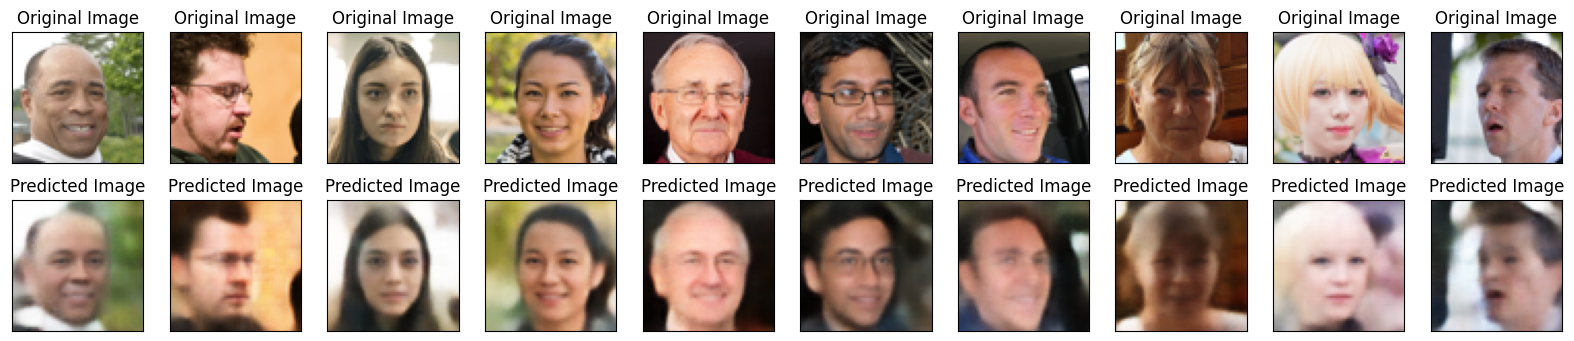

In [5]:

n = 10  ## how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ## display original
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("Original Image")
    plt.imshow(x_test[i].reshape(H, W, C))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.set_title("Predicted Image")
    plt.imshow(test_pred_y[i].reshape(H, W, C))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
history = autoencoder.history.history
plt.plot(history['val_loss'],label="test")
plt.plot(history['loss'],label="training")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graph.png')

KeyError: 'val_loss'